### Import the libraries and import the 


In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import display, Image
from ultralytics import YOLO
from os import getcwd
from PIL import Image as PILImage
import os
 
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import shutil
import random
import glob


In [3]:
# directory structure

for dirname, _, filenames in os.walk("pool-dataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

pool-dataset/data.yaml
pool-dataset/testing/labels.cache
pool-dataset/testing/images/000000000.jpg
pool-dataset/testing/images/000000001.jpg
pool-dataset/testing/images/000000002.jpg
pool-dataset/testing/images/000000003.jpg
pool-dataset/testing/images/000000004.jpg
pool-dataset/testing/images/000000005.jpg
pool-dataset/testing/images/000000006.jpg
pool-dataset/testing/images/000000007.jpg
pool-dataset/testing/images/000000008.jpg
pool-dataset/testing/images/000000009.jpg
pool-dataset/testing/images/000000010.jpg
pool-dataset/testing/images/000000011.jpg
pool-dataset/testing/images/000000012.jpg
pool-dataset/testing/images/000000013.jpg
pool-dataset/testing/images/000000014.jpg
pool-dataset/testing/images/000000015.jpg
pool-dataset/testing/images/000000016.jpg
pool-dataset/testing/images/000000017.jpg
pool-dataset/testing/images/000000018.jpg
pool-dataset/testing/images/000000019.jpg
pool-dataset/testing/images/000000020.jpg
pool-dataset/testing/images/000000021.jpg
pool-dataset/testin

In [27]:
def parse_xml(file):
    tree = ET.parse(file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):
        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = round(float(boxes.find("bndbox/ymin").text))
        xmin = round(float(boxes.find("bndbox/xmin").text))
        ymax = round(float(boxes.find("bndbox/ymax").text))
        xmax = round(float(boxes.find("bndbox/xmax").text))

        list_with_all_boxes.append([xmin, ymin, xmax, ymax])

    return filename, list_with_all_boxes

In [25]:
# Visualize image with bounding box

def visualize_image(image_folder, label_folder, label_file):
    image_file, boxes = parse_xml(os.path.join(label_folder, label_file)) # for example labels/0001.xml

    img = cv2.imread(os.path.join(image_folder, image_file))
    for box in boxes:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [21]:
training_dir = "pool-dataset/training"
training_images_dir = "pool-dataset/training/images"
training_label_dir = "pool-dataset/training/labels"

test_dir = "pool-dataset/testing"
test_images_dir = "pool-dataset/testing/images"
test_label_dir = "pool-dataset/testing/labels"

In [23]:
label_files = random.sample(os.listdir(training_label_dir), 10)

print(label_files)

['000002780.xml', '000003074.xml', '000002048.xml', '000002619.xml', '000003340.xml', '000000605.xml', '000000711.xml', '000002393.xml', '000000966.xml', '000002972.xml']


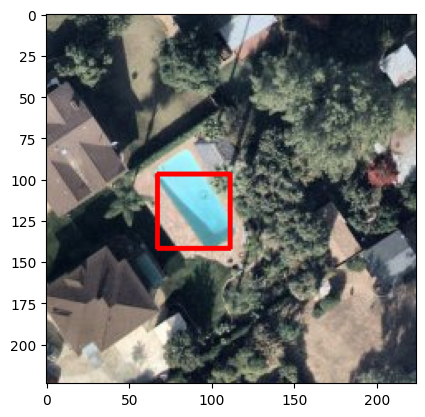

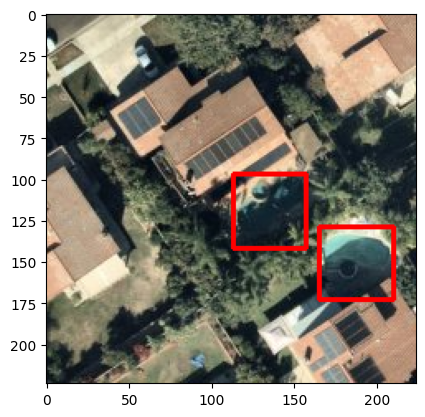

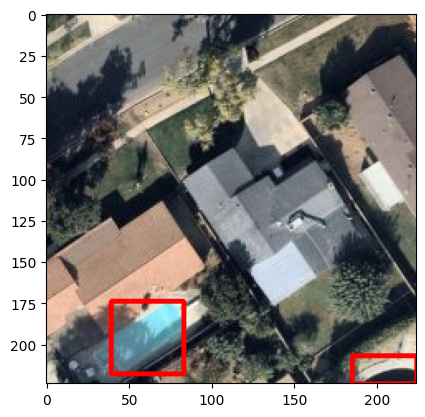

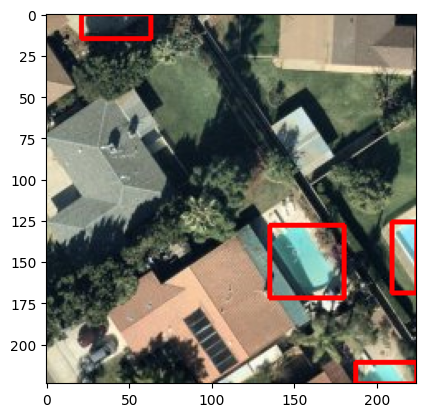

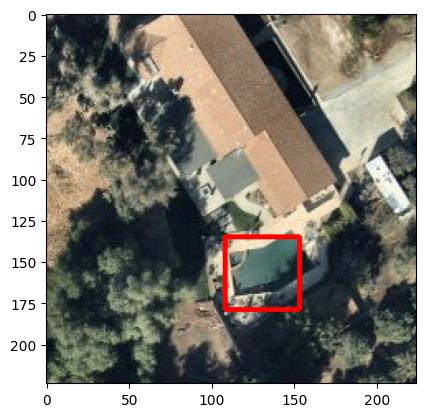

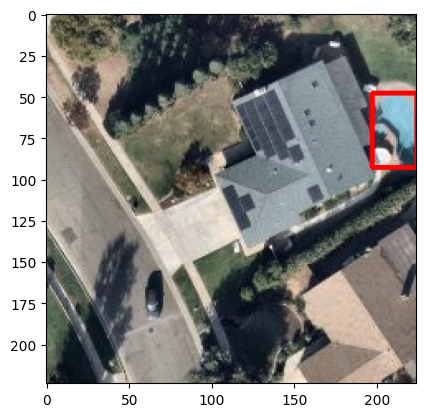

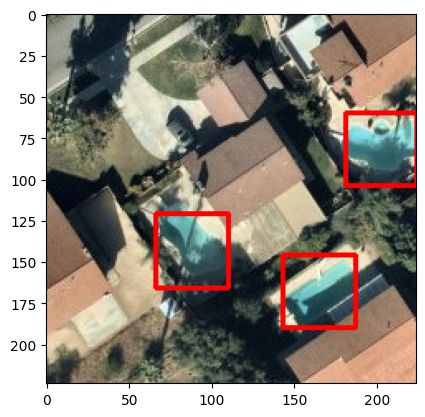

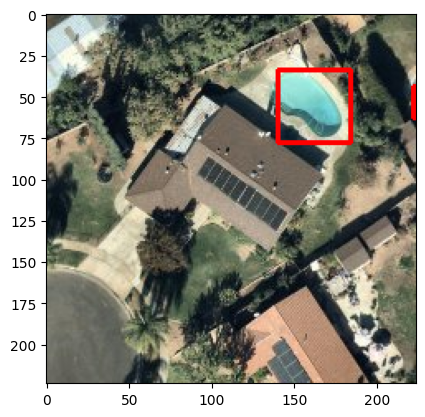

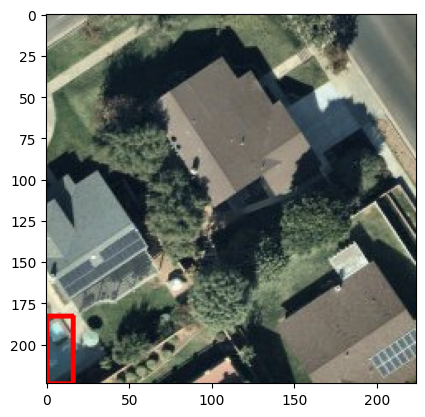

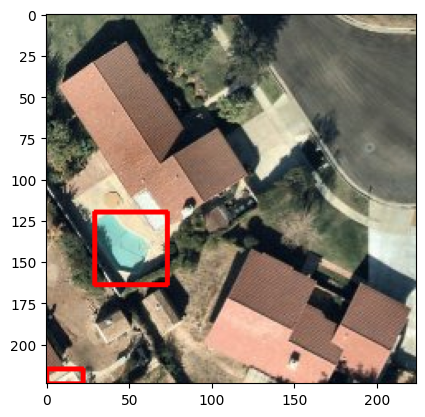

In [29]:
for lab_file in label_files:
    label_path = os.path.join(training_label_dir, lab_file)
    if os.path.exists(label_path) and os.path.getsize(label_path) > 0 and lab_file.endswith(".xml"):
        visualize_image(training_images_dir, training_label_dir, lab_file)
    else:
        print(f"Warning: {lab_file} is missing or empty.")


### Data preparation and model set

In [31]:
# function to convert coordinates to YOLO format (x_center, y_center, width, height)

def convert(size, box): # size = (width, height), box = [xmin, ymin, xmax, ymax]

    dw = 1. / size[0] # just to make sure the result is between 0 and 1
    dh = 1. / size[1] # just to make sure the result is between 0 and 1
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh

    return (x, y, w, h)



# function to convert xml labels to YOLO txt format

def convert_label_to_txt(label_dir, image_id, classes):
    in_file = open(label_dir + '/' + image_id + '.xml')
    out_file = open(label_dir + '/' + image_id + '.txt', 'w')

    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        cls = obj.find('name').text

        if cls not in classes:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')

        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))

        bb = convert((w, h), b)


        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
        
    in_file.close()
    out_file.close()
    


In [30]:
def remove_txt_files(path):
    if os.path.exists(path):
        for file in os.listdir(path):
            if file.endswith(".txt"):
                os.remove(os.path.join(path, file))

remove_txt_files(training_label_dir) 

In [33]:
# convert all labels to YOLO format
for label in os.listdir(training_label_dir):
    label_path = os.path.join(training_label_dir, label)
    if os.path.exists(label_path):
        convert_label_to_txt(training_label_dir, label.split('.')[0], ['2']) # because in xml, the class is named 2
    else:
        print(f"Warning: {label} is missing or empty.")

for label in os.listdir(test_label_dir):
    label_path = os.path.join(test_label_dir, label)
    if os.path.exists(label_path):
        convert_label_to_txt(test_label_dir, label.split('.')[0], ['pool'])
    else:
        print(f"Warning: {label} is missing or empty.")


In [34]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt') 

model.train(data="/home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/pool-dataset/data.yaml", epochs=2)




New https://pypi.org/project/ultralytics/8.3.25 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.24 🚀 Python-3.12.3 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060, 7925MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/pool-dataset/data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=F

train: Scanning /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/pool-dataset/training/labels... 1993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1993/1993 [00:00<00:00, 4234.02it/s]

train: New cache created: /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/pool-dataset/training/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/pool-dataset/testing/labels.cache... 524 images, 2179 backgrounds, 0 corrupt: 100%|██████████| 2703/2703 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/pool-dataset/testing/images/000001111.jpg: corrupt JPEG restored and saved


Plotting labels to /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/runs/detect/train
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.91G       1.94      2.233      1.751         25        640: 100%|██████████| 125/125 [00:25<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.57it/s]


                   all       2703        620      0.491      0.374      0.288     0.0589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.83G      1.723      1.313      1.605         26        640: 100%|██████████| 125/125 [00:24<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.84it/s]

                   all       2703        620      0.397      0.448      0.237     0.0509



2 epochs completed in 0.021 hours.
Optimizer stripped from /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/runs/detect/train/weights/best.pt, 22.5MB

Validating /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/runs/detect/train/weights/best.pt...
Ultralytics 8.3.24 🚀 Python-3.12.3 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060, 7925MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  7.02it/s]


                   all       2703        620      0.493      0.374      0.288     0.0588
Speed: 0.2ms preprocess, 3.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b06e60148c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [12]:
# model.val(data="/home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/pool-dataset/data.yaml")


Ultralytics 8.3.24 🚀 Python-3.12.3 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060, 7925MiB)
YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


val: Scanning /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/pool-dataset/testing/labels.cache... 524 images, 2179 backgrounds, 0 corrupt: 100%|██████████| 2703/2703 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/franciscosantos/workspace/IPVC/PROJECT_III/pool-detection-gis/pool-dataset/testing/images/000001111.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  41%|████      | 69/169 [00:08<00:12,  8.10it/s]


KeyboardInterrupt: 